In [38]:
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Bidirectional
from keras.callbacks import ModelCheckpoint
import numpy as np
import math
import random
import nltk
from pickle import dump, load
from os import makedirs
from datetime import datetime
import matplotlib.pyplot as plt

* [Предобработка текстов](#prep)
* [Подготовка и векторизация данных](#vec)
* [Создание и обучение моделей](#train)
    * [LSTM](#lstm)
    * [BiLSTM](#bilstm)
    * [GRU](#gru)
* [Оценка моделей, подсчёт перплексии](#eval)
* [Эксперименты с размерностью эмбеддингов](#embed)

# Предобработка текстов <a id="prep"></a>

Генерить так генерить, так что соханим некоторые знаки препинания (запятые,, двоеточия, знаки конца предложения) и не будем лемматизировать текст.

In [6]:
def clean(text): 
    text = text.replace('\n',' . ') # всякие заголовки пусть считаются отдельными предложениями
    
    text = text.replace('—', '')
    text = text.replace('(','')
    text = text.replace(')','')
    text = text.replace('[','')
    text = text.replace(']','')
    text = text.replace('/','')
    text = text.replace('«', '')
    text = text.replace('»', '')
    text = text.replace('"','')
    text = text.replace('*','')
    
    # оставим запятые, двоеточия, дефисы. Запяточия превратим в точки -- всё равно они ближке к ним.
    text = text.replace('?..','?')
    text = text.replace('!..','!')
    text = text.replace('...','.')
    text = text.replace(';','.')
    
    return text

In [7]:
def divide(text):
    tokens = []
    for sentence in nltk.sent_tokenize(text):
        #print(sentence)
        toks = nltk.word_tokenize(sentence)
        #print(toks)
        if len(toks) == 1 and toks[0] == '.': # попадаются, если было несколько \n подряд
            continue
        else:
            tokens.extend(toks)
    return tokens

In [8]:
def get_data(filename):
    raw = open('{}.txt'.format(filename), encoding='utf-8').read().lower()
    text = clean(raw)
    tokens = divide(text)
    dump(tokens, open('{}.pkl'.format(filename), 'wb'))
    return tokens

In [9]:
train = get_data('Эрагон')[:100000] # они длиннющие, и так хватит
len(train)

100000

In [10]:
test = get_data('Возвращение')[:10000] # тем более на оценку 260+ тысяч не надо
len(test)

10000

# Подготовка и векторизация данных <a id="vec"></a>

In [11]:
train_words = set(train)
train_vocab = len(train_words)
train2index = {w: i for i, w in enumerate(train_words)}
index2train = {i: w for i, w in enumerate(train_words)}
print(train_vocab)

16497


Удалим из тестового корпуса все слова, которые не сможем предсказать. Местами стало не сильно связно, правда, но это ерунда по сравнению с тем, что наш новый тестовый корпус состоит всего из 2 с хвостиком тысяч слов.

In [37]:
test_clean = [w for w in test if w in train_words]
print(len(set(test_clean)))
print(len(test_clean))
print(test_clean[:100])

2087
8512
['кристофер', 'паолини', '.', 'эрагон', '.', '.', 'беда', '.', 'песни', 'мертвых', 'это', 'живых', 'так', 'думал', 'эрагон', ',', 'через', ',', 'тела', 'ургалов', 'и', 'слушая', 'женщин', ',', 'которые', 'убитых', 'с', 'кровью', 'земли', '.', 'сапфира', 'шла', 'рядом', ',', 'стараясь', 'не', 'на', 'мертвецов', '.', 'сверкающая', 'чешуя', 'драконихи', 'была', ',', 'казалось', ',', 'единственным', ',', 'что', 'свет', 'во', ',', 'внутри', 'горы', '.', 'три', 'дня', 'с', 'тех', 'пор', ',', 'как', 'вардены', 'и', 'гномы', 'с', 'ургалами', 'за', ',', 'невероятным', 'городом', ',', 'гномами', 'внутри', 'горы', ',', 'в', 'самом', 'сердце', ',', 'но', 'поле', 'все', 'еще', 'следы', '.', 'мертвых', 'оказалось', 'так', 'много', ',', 'что', 'не', 'хватало', 'сил', 'похоронить', 'их', 'всех', 'вовремя', '.']


In [13]:
seqlen = 5 # будем смотреть на 5 предыдущих слов
batch_size = 64

Превратим наши коропуса в последовательности слов с метками и закодируем

In [14]:
train_inputs = []
train_labels = []
for i in range(0, len(train) - seqlen):
    train_inputs.append(train[i:i + seqlen])
    train_labels.append(train[i + seqlen])

In [15]:
test_inputs = []
test_labels = []
for i in range(0, len(test_clean) - seqlen):
    test_inputs.append(test_clean[i:i + seqlen])
    test_labels.append(test_clean[i + seqlen])

In [16]:
for i in range(10):
    print(train_inputs[i], train_labels[i])

['кристофер', 'паолини', '.', 'эрагон', '.'] пролог
['паолини', '.', 'эрагон', '.', 'пролог'] .
['.', 'эрагон', '.', 'пролог', '.'] тень
['эрагон', '.', 'пролог', '.', 'тень'] страха
['.', 'пролог', '.', 'тень', 'страха'] .
['пролог', '.', 'тень', 'страха', '.'] ветер
['.', 'тень', 'страха', '.', 'ветер'] выл
['тень', 'страха', '.', 'ветер', 'выл'] в
['страха', '.', 'ветер', 'выл', 'в'] ночи
['.', 'ветер', 'выл', 'в', 'ночи'] ,


In [17]:
def encode_input(inputs):
    enc_inputs = np.zeros((len(inputs), seqlen))
    for i, inpt in enumerate(inputs):
        for w, word in enumerate(inpt):
            #print('word', word)
            #print(train2index[word])
            enc_inputs[i, w] = train2index[word]
    return enc_inputs

In [18]:
def onehot_label(labels):
    enc_labels = np.zeros((len(labels), train_vocab))
    for i, label in enumerate(labels):
        enc_labels[i, train2index[label]] = 1
    return enc_labels

In [19]:
# проверим, как работает
es = encode_input(train_inputs[:2])
print(es.shape)
et = onehot_label(train_labels[:2])
print(et.shape)

for i in range(2):
    print(train_inputs[i]),
    print(es[i]),
    print(train_labels[i]),
    print(et[i]),
    print()

(2, 5)
(2, 16497)
['кристофер', 'паолини', '.', 'эрагон', '.']
[10412.  8969.  3153. 13700.  3153.]
пролог
[0. 0. 0. ... 0. 0. 0.]

['паолини', '.', 'эрагон', '.', 'пролог']
[ 8969.  3153. 13700.  3153. 12992.]
.
[0. 0. 0. ... 0. 0. 0.]



In [20]:
# снова воспользуемся генератором
def gen_batch(inputs, labels, batch_size):
    i = 0
    all_inputs  = len(inputs) # всего последовательностей
    n_inputs = batch_size * int(all_inputs / batch_size)  #сколько у нас влезет (батч * кол-во батчей)
    #print(n_inputs)
    while True:
        #print(i)
        i = i % n_inputs # считаем текущий индекс (где новое)
        # берём кусочки
        sub_inputs = inputs[i: i+batch_size]
        sub_labels = labels[i: i+batch_size]

        # кодируем кусочки
        sub_inputs = encode_input(sub_inputs)
        sub_labels = onehot_label(sub_labels)
        
        # обновляем текущий индекс
        i += batch_size
        #print(i)
        
        yield sub_inputs, sub_labels # возвращаем наши кусочки

# Создание и обучение моделей <a id="train"></a>

In [21]:
embed_size = 100
hidden_size = 128
iters = 15
epochs = 1
steps = int(len(train_inputs)/batch_size)
print(steps)
test_steps = int(len(test_inputs)/batch_size)
print(test_steps)
epoch_preds = 5

1562
132


По ходу обучения мы будем после каждой итерации (фактически после каждой эпохи) генерировать продолжение для случайной последовательности тренировочного корпуса

In [22]:
def train_model(model, model_type):
    try:
        makedirs('{}'.format(model_type))
    except OSError:
        pass
    
    for it in range(iters):
        print('=' * 50)
        print('Iteration {}'.format(it+1))
        model.fit_generator(gen_batch(train_inputs, train_labels, batch_size), epochs=epochs, steps_per_epoch=steps)

        test_input = random.choice(train_inputs)
        print(' '.join(test_input), end = ' -> ')
        for i in range(epoch_preds):
            test_seq = np.zeros((1, seqlen)) # кодируем эту последовательность, чтобы по ней предсказать
            for w, word in enumerate(test_input):
                test_seq[0, w] = train2index[word]
            pred = model.predict(test_seq, verbose=0)[0]
            pred_w = index2train[np.argmax(pred)]
            print(pred_w, end=" ")
            # move forward with test_chars + ypred
            test_input = test_input[1:] + [pred_w]
        print()
        model.save('{}\\LM-{}.h5'.format(model_type, it+1))

Применим LSTM, GRU и посмотрим, как сработает BiLSTM. По идее, при генерации текста у нас нет возможности заглянуть вперёд, поэтому обучать бинаправленную модель не имеет смысла, наверное, но эксперимента ради

# LSTM <a id="lstm"></a>

In [29]:
lstm_model = Sequential()
lstm_model.add(Embedding(train_vocab, embed_size, input_length=seqlen))
lstm_model.add(LSTM(hidden_size, return_sequences=False, unroll=True))
lstm_model.add(Dense(train_vocab, activation="softmax"))

lstm_model.compile(loss="categorical_crossentropy", optimizer="rmsprop")
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5, 100)            1649700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 16497)             2128113   
Total params: 3,895,061
Trainable params: 3,895,061
Non-trainable params: 0
_________________________________________________________________


In [30]:
train_model(lstm_model, 'lstm')

Iteration 1
Epoch 1/1
1562/1562 [==============================] - 394s 252ms/step - loss: 7.1210
ветка , и шейд сердито -> , что , что , 
Iteration 2
Epoch 1/1
1562/1562 [==============================] - 367s 235ms/step - loss: 6.7679
теплым одеялом . его израненные -> , что ты , что 
Iteration 3
Epoch 1/1
1562/1562 [==============================] - 365s 234ms/step - loss: 6.5462
из последних шатров . он -> , но он не ней 
Iteration 4
Epoch 1/1
1562/1562 [==============================] - 361s 231ms/step - loss: 6.3197
аруфс стоит слишком на отшибе -> , но он уже не 
Iteration 5
Epoch 1/1
1562/1562 [==============================] - 360s 230ms/step - loss: 6.1404
внутреннее зрение : драумр копа -> , что ты не не 
Iteration 6
Epoch 1/1
1562/1562 [==============================] - 362s 232ms/step - loss: 5.9817
с тихим ворчанием попрятались и -> гораздо стрелы . а ты 
Iteration 7
Epoch 1/1
1562/1562 [==============================] - 360s 231ms/step - loss: 5.8328
с всадниками . значи

# BiLSTM <a id="bilstm"></a>

In [31]:
bilstm_model = Sequential()
bilstm_model.add(Embedding(train_vocab, embed_size, input_length=seqlen))
bilstm_model.add(Bidirectional(LSTM(hidden_size, return_sequences=False, unroll=True)))
bilstm_model.add(Dense(train_vocab, activation="softmax"))

bilstm_model.compile(loss="categorical_crossentropy", optimizer="rmsprop")
bilstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 5, 100)            1649700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dense_2 (Dense)              (None, 16497)             4239729   
Total params: 6,123,925
Trainable params: 6,123,925
Non-trainable params: 0
_________________________________________________________________


In [32]:
train_model(bilstm_model, 'bilstm')

Iteration 1
Epoch 1/1
1562/1562 [==============================] - 381s 244ms/step - loss: 7.0712
перчатки , если они у -> него . и , что 
Iteration 2
Epoch 1/1
1562/1562 [==============================] - 382s 244ms/step - loss: 6.6541
нашим далеким предкам понадобилось целых -> . а ты же не 
Iteration 3
Epoch 1/1
1562/1562 [==============================] - 383s 245ms/step - loss: 6.3766
срезав их с колючих вьющихся -> . а ты бы не 
Iteration 4
Epoch 1/1
1562/1562 [==============================] - 381s 244ms/step - loss: 6.1345
издает долгий , исполненный страдания -> , и в камень , 
Iteration 5
Epoch 1/1
1562/1562 [==============================] - 392s 251ms/step - loss: 5.9502
рассмеялся эрагон . я и -> не смогу магии , что 
Iteration 6
Epoch 1/1
1562/1562 [==============================] - 391s 250ms/step - loss: 5.7999
в этом уверен , загадочно -> сказала эрагон , но в 
Iteration 7
Epoch 1/1
1562/1562 [==============================] - 393s 252ms/step - loss: 5.6621
давать сове

# GRU <a id="gru"></a>

In [33]:
gru_model = Sequential()
gru_model.add(Embedding(train_vocab, embed_size, input_length=seqlen))
gru_model.add(GRU(hidden_size, return_sequences=False, unroll=True))
gru_model.add(Dense(train_vocab, activation="softmax"))

gru_model.compile(loss="categorical_crossentropy", optimizer="rmsprop")
gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 5, 100)            1649700   
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               87936     
_________________________________________________________________
dense_3 (Dense)              (None, 16497)             2128113   
Total params: 3,865,749
Trainable params: 3,865,749
Non-trainable params: 0
_________________________________________________________________


In [34]:
train_model(gru_model, 'gru')

Iteration 1
Epoch 1/1
1562/1562 [==============================] - 305s 195ms/step - loss: 7.0502
всего второго этажа . водосточные -> , что ты не него 
Iteration 2
Epoch 1/1
1562/1562 [==============================] - 306s 196ms/step - loss: 6.6281s - loss: 6
подвал и торжественно пообещали мне -> не него . эрагон , 
Iteration 3
Epoch 1/1
1562/1562 [==============================] - 291s 186ms/step - loss: 6.3588
не думаю , что раззаки -> , что ты не не 
Iteration 4
Epoch 1/1
1562/1562 [==============================] - 292s 187ms/step - loss: 6.1556
не вернемся . может , -> что ты не просто не 
Iteration 5
Epoch 1/1
1562/1562 [==============================] - 290s 186ms/step - loss: 6.0005
потом повернулся к хелен и -> стал , что он не 
Iteration 6
Epoch 1/1
1562/1562 [==============================] - 291s 186ms/step - loss: 5.8768
головы ! охладил его пыл -> . эрагон , и эрагон 
Iteration 7
Epoch 1/1
1562/1562 [==============================] - 293s 188ms/step - loss: 5.7836
эраг

Все три модели к 15 итерации порождают довольно неплохие кусочки текста

# Оценка моделей, подсчёт перплексии <a id="eval"></a>

Посчитаем перплексию моделей на тестовом тексте

In [23]:
def perplexity(probs):
    logsum = 0
    for prob in probs:
        log_prob = math.log2(prob)
        #print(log_prob)
        logsum += log_prob
        #print(logsum)
        #print()
    l = logsum/len(probs)
    #print(l)
    perplex = math.pow(2, -l)
    #print(perplex)
    return perplex

In [24]:
def eval_model(model):
    probs = []
    for i in range(len(test_inputs)): # для каждой последовательности в тестовой выборке
        #print("Iteration {}".format(i+1))
        test_input = test_inputs[i]
        test_label = test_labels[i]
        #print(test_input, test_label, sep=' -> ', end=' ')
        test_seq = np.zeros((1, seqlen)) # кодируем эту последовательность, чтобы по ней предсказать
        for w, word in enumerate(test_input):
            test_seq[0, w] = train2index[word]
        pred = model.predict(test_seq, verbose=0)[0]
        #print(len(pred), pred)
        prob = pred[train2index[test_label]] # берём вероятность с нужного индекса 
        probs.append(prob)
        #print(prob)
    perplex = perplexity(probs)
    #print('\nPerplexity: {}'.format(perplex))
    return perplex

In [37]:
print(datetime.now())
lstm_perplex = eval_model(lstm_model)
print(datetime.now())
bilstm_perplex = eval_model(bilstm_model)
print(datetime.now())
gru_perplex = eval_model(gru_model)
print(datetime.now())

2019-01-15 08:28:53.520043
2019-01-15 08:29:23.411906
2019-01-15 08:30:02.573542
2019-01-15 08:30:31.480971


In [38]:
print('''
LSTM:\t{}
BiLSTM:\t{}
GRU:\t{}'''.format(round(lstm_perplex, 3), round(bilstm_perplex, 3), round(gru_perplex, 3)))


LSTM:	1770.162
BiLSTM:	1707.516
GRU:	1624.744


Кажется, это не очень хорошие результаты, хотя они и объяснимы тем, что у нас и слов-то в тестовом корпусе не осталось толком :с А BiLSTM показала перплексию ниже, чем обычная LSTM. Посмотрим, как переплексия моделей менялась с течением времени.

In [25]:
def history(model_type):
    model_history = []
    for it in range(iters):
        model = load_model('{}\\LM-{}.h5'.format(model_type, it+1))
        print('Оцениваю модель {}-{}'.format(model_type, it+1))
        perplex = eval_model(model)
        print(datetime.now())
        model_history.append(perplex)
    return model_history

In [40]:
print(datetime.now())
lstm_history = history('lstm')

2019-01-15 08:30:31.947817
Оцениваю модель lstm-1
2019-01-15 08:31:10.291050
Оцениваю модель lstm-2
2019-01-15 08:31:47.112981
Оцениваю модель lstm-3
2019-01-15 08:32:25.554944
Оцениваю модель lstm-4
2019-01-15 08:33:06.452502
Оцениваю модель lstm-5
2019-01-15 08:33:50.890789
Оцениваю модель lstm-6
2019-01-15 08:34:35.251202
Оцениваю модель lstm-7
2019-01-15 08:35:19.250822
Оцениваю модель lstm-8
2019-01-15 08:36:05.349399
Оцениваю модель lstm-9
2019-01-15 08:36:51.749819
Оцениваю модель lstm-10
2019-01-15 08:37:39.743308
Оцениваю модель lstm-11
2019-01-15 08:38:29.751127
Оцениваю модель lstm-12
2019-01-15 08:39:21.287718
Оцениваю модель lstm-13
2019-01-15 08:40:09.776948
Оцениваю модель lstm-14
2019-01-15 08:41:02.213890
Оцениваю модель lstm-15
2019-01-15 08:41:55.308554


In [41]:
print(datetime.now())
bilstm_history = history('bilstm')

2019-01-15 08:41:55.366523
Оцениваю модель bilstm-1
2019-01-15 08:43:02.427474
Оцениваю модель bilstm-2
2019-01-15 08:44:12.470324
Оцениваю модель bilstm-3
2019-01-15 08:45:26.365622
Оцениваю модель bilstm-4
2019-01-15 08:46:46.314368
Оцениваю модель bilstm-5
2019-01-15 08:48:06.426901
Оцениваю модель bilstm-6
2019-01-15 08:49:29.728032
Оцениваю модель bilstm-7
2019-01-15 08:50:57.721389
Оцениваю модель bilstm-8
2019-01-15 08:52:30.085440
Оцениваю модель bilstm-9
2019-01-15 08:54:07.723006
Оцениваю модель bilstm-10
2019-01-15 08:55:43.972943
Оцениваю модель bilstm-11
2019-01-15 08:57:29.948372
Оцениваю модель bilstm-12
2019-01-15 08:59:15.146255
Оцениваю модель bilstm-13
2019-01-15 09:01:05.509387
Оцениваю модель bilstm-14
2019-01-15 09:03:08.956070
Оцениваю модель bilstm-15
2019-01-15 09:05:05.541615


In [42]:
print(datetime.now())
gru_history = history('gru')

2019-01-15 09:05:05.558586
Оцениваю модель gru-1
2019-01-15 09:06:39.432915
Оцениваю модель gru-2
2019-01-15 09:08:08.187999
Оцениваю модель gru-3
2019-01-15 09:09:42.779461
Оцениваю модель gru-4
2019-01-15 09:11:16.636730
Оцениваю модель gru-5
2019-01-15 09:12:54.690997
Оцениваю модель gru-6
2019-01-15 09:14:29.980435
Оцениваю модель gru-7
2019-01-15 09:16:08.255676
Оцениваю модель gru-8
2019-01-15 09:17:50.251782
Оцениваю модель gru-9
2019-01-15 09:19:29.243488
Оцениваю модель gru-10
2019-01-15 09:21:10.808935
Оцениваю модель gru-11
2019-01-15 09:23:07.069445
Оцениваю модель gru-12
2019-01-15 09:24:52.177151
Оцениваю модель gru-13
2019-01-15 09:26:49.077365
Оцениваю модель gru-14
2019-01-15 09:28:34.738468
Оцениваю модель gru-15
2019-01-15 09:30:23.555363


In [26]:
def vis_perplexity(model_history, model_type):
    perplexity = model_history
    epochs = [e+1 for e in range(iters)]

    plt.plot(epochs, perplexity, 'b')
    plt.title(model_type)
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')

    plt.show()

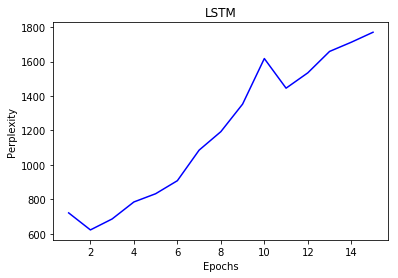

In [44]:
vis_perplexity(lstm_history, 'LSTM')

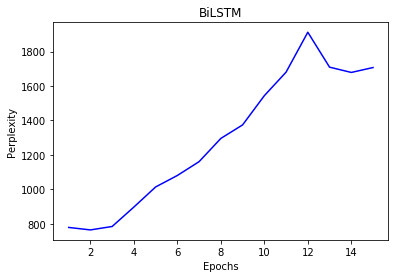

In [45]:
vis_perplexity(bilstm_history, 'BiLSTM')

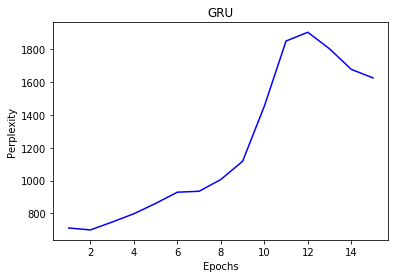

In [46]:
vis_perplexity(gru_history, 'GRU')

Поначалу перплексия относительно низкая, но со временем растёт всё быстрей, а затем снова начинает уменьшаться

Теперь попробуем сгенерировать текст, начиная со случайной последовательности тестовой выборки

In [51]:
gen_len = 300 # предскажем 300 слов
start_idx = random.randint(0, len(test_inputs))# начнём с последовательности тестового текста и продолжим, но для удобства сравнения случайная последовательность будет для всех моделей общая
print(start_idx)
print(test_inputs[start_idx])

3351
['доброе', 'ли', '?', 'он', 'посмотрел']


In [27]:
def inference(model):
    test_input = test_inputs[start_idx] # начнём с последовательности тестового текста и продолжим
    print(' '.join(test_input), end = ' -> ')
    for step in range(gen_len):
        test_seq = np.zeros((1, seqlen)) # кодируем эту последовательность, чтобы по ней предсказать
        for w, word in enumerate(test_input):
            test_seq[0, w] = train2index[word]
        pred = model.predict(test_seq, verbose=0)[0]
        variants = [] # варианты будущего слова
        for i in range(3):
            max_idx = np.argmax(pred)
            pred_w = index2train[max_idx]
            variants.append(pred_w)
            pred[max_idx] = 0 # обнуляем текущий максимум и выбираем снова
        #print(variants)
        new_w = random.choice(variants)
        print(new_w, end=" ")
        test_input = test_input[1:] + [new_w]
    print()

In [53]:
inference(lstm_model)

доброе ли ? он посмотрел -> в ней : не только в этом не помощью тебя и не по свете было бы , как в же с ней не так и не было бы не в этом свете ни о них и тебе не в этом свете тебе не в этом и тебе в ней не в руке ? было быть ! ты не так ты не в нем с на него не было всех всех него не всех ни о нем помощью тебя не было в свете . в случае так не было в этом случае . в этом свете не в этом него не было него помощью в свете ни в том , как ты на него и гораздо без время всех этом или в том и с бромом на этом не к всех этом ней , как в же сторону не было , а что и не на него так не него было в сторону и не было бы в ней . он с помощью бы в помощью этом свете , как на свете , и в сторону , но я просто не помощью того ? тебе быть бы тебя и ни было из помощью него ни ее и не помощью всех ни бы не было в сторону и с помощью свете . я с не в помощью случае , или в этом так что ? в эрагон с не помощью было помощью его не было бы в сторону и с ней , не к ней его не было . эрагон с помощью из этом 

In [54]:
inference(bilstm_model)

доброе ли ? он посмотрел -> в и , с помощью и в и к к с бромом , но , . ты и не только на берегу , в свете . в и ты не , и он не в руке с таких , но в , на свете , с , если ты , в , в , на на берегу он с , : ты , с помощью , из свете , с бромом , он не смогу , но в , он и , в , в и в , с и , в и в , с и таких в и , из и эрагон , с и нем с , пока он с не на него , и в воздухе что на берегу . в и ты не с и , в , на к тебя . и в воздухе , к а до с в , в , с , всех с ними . на тебя , но в свете . в , с таких на в с бромом , не , и , с бромом . но с помощью : из к не свете . и на к к к к не , с бромом к к себе , в воздухе ты . к тому и в , , если ты и не в , и он не на к к не , . в воздухе что , тебя в том , что в нем , из свете к бромом . эрагон , . он с помощью и и , в руке . к бромом . он не к а на таких таких , в свете . и , если в , с на к к себе , и , с в и , в на к а потом и в , в воздухе что , с таких 


In [55]:
inference(gru_model)

доброе ли ? он посмотрел -> на него , но с помощью несколько и , с ним не было в , и эрагон не в : . в , не в или же ты с из всего в или в ? . эрагон и не в . , и , . он , , , , эрагон и , как , и с ним не и с помощью . он было , как он , как , , , и он , и в , . он , и в . не , не , и он , как только на , и он , с помощью в или было бы в о чем он ни в , чтобы эрагон , как в из , он не было в или же не в , . ты и , не в или было не в , но , , эрагон , не , и . в или было не на или , . эрагон не в или же , не на или , , эрагон и с из , , эрагон , , и эрагон не на , и эрагон . в или было , как можно было , чтобы эрагон не было бы с помощью . но с была не и , , чтобы , , эрагон , не было , и эрагон не на , . эрагон , не , и . с ним не было не , , и эрагон . в или было , как бы эрагон не в , и он с из не и в : . в или не , , он . с помощью несколько в , и он с из , он не было в или , не в ? не и с ним , не было бы и , не было бы , что эрагон , как 


Забавно, что bilstm научилась предсказывать по большей части союзы, предлогии знаки препинания. Все тексты отвратительны, но у lstm это хотя бы на текст визуально похже

# Эксперименты с размерностью эмбеддингов <a id="embed"></a>

Для экспериментов выберем lstm. Интересно, повлияет ли на языковую модель размерность эмбеддингов 

In [33]:
# пришлось переопределить, чтобы включать в назания файлов размерность эмбеддингов
def train_model(model, model_type, name):
    for it in range(iters):
        print('=' * 50)
        print('Iteration {}'.format(it+1))
        model.fit_generator(gen_batch(train_inputs, train_labels, batch_size), epochs=epochs, steps_per_epoch=steps)

        # testing model
        # randomly choose a row from input_chars, then use it to 
        # generate text from model for next 100 chars
        test_input = random.choice(train_inputs)
        print(' '.join(test_input), end = ' -> ')
        for i in range(epoch_preds):
            test_seq = np.zeros((1, seqlen)) # кодируем эту последовательность, чтобы по ней предсказать
            for w, word in enumerate(test_input):
                test_seq[0, w] = train2index[word]
            pred = model.predict(test_seq, verbose=0)[0]
            pred_w = index2train[np.argmax(pred)]
            print(pred_w, end=" ")
            # move forward with test_chars + ypred
            test_input = test_input[1:] + [pred_w]
        print()
        model.save('{}\\{}-{}.h5'.format(model_type, name, it+1))

In [34]:
def history(model_type, name):
    model_history = []
    for it in range(iters):
        model = load_model('{}\\{}-{}.h5'.format(model_type, name, it+1))
        print('Оцениваю модель {}-{}'.format(name, it+1))
        perplex = eval_model(model)
        print(datetime.now())
        model_history.append(perplex)
    return model_history

### 50

In [46]:
lstm_50 = Sequential()
lstm_50.add(Embedding(train_vocab, 50, input_length=seqlen))
lstm_50.add(LSTM(hidden_size, return_sequences=False, unroll=True))
lstm_50.add(Dense(train_vocab, activation="softmax"))

lstm_50.compile(loss="categorical_crossentropy", optimizer="rmsprop")
lstm_50.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 5, 50)             824850    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_3 (Dense)              (None, 16497)             2128113   
Total params: 3,044,611
Trainable params: 3,044,611
Non-trainable params: 0
_________________________________________________________________


In [65]:
train_model(lstm_50, 'lstm', 'lstm_50')

Iteration 1
Epoch 1/1
1562/1562 [==============================] - 524s 335ms/step - loss: 7.1341
отмахнуться . вот только захочет -> , , , , , 
Iteration 2
Epoch 1/1
1562/1562 [==============================] - 452s 290ms/step - loss: 6.8043
. вот бром хороший человек -> , но ты , что 
Iteration 3
Epoch 1/1
1562/1562 [==============================] - 467s 299ms/step - loss: 6.5971
что во всем есть доля -> , но он , что 
Iteration 4
Epoch 1/1
1562/1562 [==============================] - 473s 303ms/step - loss: 6.3852
встал во весь рост и -> ургалы , что ты не 
Iteration 5
Epoch 1/1
1562/1562 [==============================] - 476s 305ms/step - loss: 6.2110
говорил медленно , четко произнося -> , но он , но 
Iteration 6
Epoch 1/1
1562/1562 [==============================] - 475s 304ms/step - loss: 6.0764
сил и высокая самодисциплина . -> а ты не не не 
Iteration 7
Epoch 1/1
1562/1562 [==============================] - 492s 315ms/step - loss: 5.9658
хребта в поисках перевала . -> а ты н

На тренировочном корпусе текст генерируется средненько

### 150

In [31]:
lstm_150 = Sequential()
lstm_150.add(Embedding(train_vocab, 150, input_length=seqlen))
lstm_150.add(LSTM(hidden_size, return_sequences=False, unroll=True))
lstm_150.add(Dense(train_vocab, activation="softmax"))

lstm_150.compile(loss="categorical_crossentropy", optimizer="rmsprop")
lstm_150.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 5, 150)            2474550   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               142848    
_________________________________________________________________
dense_2 (Dense)              (None, 16497)             2128113   
Total params: 4,745,511
Trainable params: 4,745,511
Non-trainable params: 0
_________________________________________________________________


In [35]:
train_model(lstm_150, 'lstm', 'lstm_150') # остановида на 10 эпохах

Iteration 1
Epoch 1/1
1562/1562 [==============================] - 340s 217ms/step - loss: 7.0859
опухоль , которая вроде бы -> , что , что , 
Iteration 2
Epoch 1/1
1562/1562 [==============================] - 327s 209ms/step - loss: 6.7013
взять небольшой камень и бросить -> , что ты не , 
Iteration 3
Epoch 1/1
1562/1562 [==============================] - 373s 239ms/step - loss: 6.4514
такие эти чужаки ? может -> , что ты не не 
Iteration 4
Epoch 1/1
1562/1562 [==============================] - 348s 223ms/step - loss: 6.2209
. он здесь с первых -> ургалов , но не прочим 
Iteration 5
Epoch 1/1
1562/1562 [==============================] - 336s 215ms/step - loss: 6.0377
: хелгринд ! ах да -> , что ты не не 
Iteration 6
Epoch 1/1
1562/1562 [==============================] - 337s 216ms/step - loss: 5.8724
на кадоке ? честно говоря -> , что ты не не 
Iteration 7
Epoch 1/1
1562/1562 [==============================] - 334s 214ms/step - loss: 5.7246
кто они , эти коты-оборотни -> в том , что т

KeyboardInterrupt: 

In [68]:
print(datetime.now())
lstm_50_history = history('lstm', 'lstm_50')

2019-01-15 20:40:40.763932
Оцениваю модель lstm_50-1
2019-01-15 20:43:45.205296
Оцениваю модель lstm_50-2
2019-01-15 20:46:41.947252
Оцениваю модель lstm_50-3
2019-01-15 20:49:48.530500
Оцениваю модель lstm_50-4
2019-01-15 20:52:44.009078
Оцениваю модель lstm_50-5
2019-01-15 20:55:46.756672
Оцениваю модель lstm_50-6
2019-01-15 20:58:43.243354
Оцениваю модель lstm_50-7
2019-01-15 21:01:48.939013
Оцениваю модель lstm_50-8
2019-01-15 21:04:56.049335
Оцениваю модель lstm_50-9
2019-01-15 21:08:07.209410
Оцениваю модель lstm_50-10
2019-01-15 21:12:02.362753
Оцениваю модель lstm_50-11
2019-01-15 21:15:17.103532
Оцениваю модель lstm_50-12
2019-01-15 21:18:31.939577
Оцениваю модель lstm_50-13
2019-01-15 21:21:50.450785
Оцениваю модель lstm_50-14
2019-01-15 21:25:08.335878
Оцениваю модель lstm_50-15
2019-01-15 21:28:30.561996


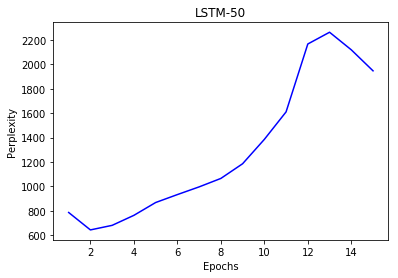

In [70]:
vis_perplexity(lstm_50_history, 'LSTM-50')

А график похож на то, что мы видели у предыдущих моделей

In [71]:
inference(lstm_50)

доброе ли ? он посмотрел -> в том , что в нем из нем время же , но же берегу из них не ни не пришлось в нем в этом случае ли же же не было из том в том , но и его в том в нем в этом в воздухе время ты не всего ни в этом том в том . и в воздухе , но же же же с ним в воздухе ! а это было время , чтобы его из нем из том в том и , глаза в случае же бы не так , что же бы в воздухе случае , которые в нем время не хватит ! но ведь , если бы в бромом из том на берегу в воздухе , которые я не нем , чтобы он не бы не плечами в этом ты бы в том в том и в воздухе из время время в том , и наконец в берегу него с помощью всех ли в том , но на него из том в том на эрагона , но и не ни на нем из них время же же в воздухе . он гальбаторикс из время , если я просто бы не было ни в том в этом . которые ургалов с не было , которые это бы не было в нем время берегу из время же воздухе тебя с бромом , ни в нем не могу и с том , как на воздухе берегу ли бы бы бы в воздухе случае ли же не было из нем случае ,

In [53]:
# старое
inference(lstm_model)

доброе ли ? он посмотрел -> в ней : не только в этом не помощью тебя и не по свете было бы , как в же с ней не так и не было бы не в этом свете ни о них и тебе не в этом свете тебе не в этом и тебе в ней не в руке ? было быть ! ты не так ты не в нем с на него не было всех всех него не всех ни о нем помощью тебя не было в свете . в случае так не было в этом случае . в этом свете не в этом него не было него помощью в свете ни в том , как ты на него и гораздо без время всех этом или в том и с бромом на этом не к всех этом ней , как в же сторону не было , а что и не на него так не него было в сторону и не было бы в ней . он с помощью бы в помощью этом свете , как на свете , и в сторону , но я просто не помощью того ? тебе быть бы тебя и ни было из помощью него ни ее и не помощью всех ни бы не было в сторону и с помощью свете . я с не в помощью случае , или в этом так что ? в эрагон с не помощью было помощью его не было бы в сторону и с ней , не к ней его не было . эрагон с помощью из этом 

Я, честно говоря, даже затрудняюсь сказать, какой текст бессвязнее

In [42]:
inference(lstm_150)

доброе ли ? он посмотрел -> на него : а если ты еще бы и он не хотелось бы в он не мог бы ты не хочу ! эрагон с стороны с не горах ! но если ты и что с не гэрроу и гэрроу . а ты что не было , чтобы я не хотелось гэрроу и что в он с ним гэрроу , а что ты не хотелось бы в что ты с тобой , что ты купцы и если бы ты не хотелось в что они когда я уже не было в карвахолл . но вот уж и , но я не хотелось , как бы гэрроу . и эрагон , если ты не что не было , а когда когда он тут в алагейзии , когда я что на камень камень и купцы не мог бы ты бы и , что ты не нашел ! эрагон с ним ее гэрроу , а а что он не было бы бы с а я не мог бы гэрроу , но , а на я не нашел ! но он гэрроу и с тобой с ним не а , если они правда в камень , роран и на камень гэрроу , а не было и роран , когда я не могу , чтобы гэрроу и в гэрроу . когда они правда , не роран . я не хочу , но он совершенно не мог бы бы , если я не что в эрагон с камень с ним на него , но не когда они они что а если ты и , что они на что ты , есл

Ну, это уже куда ни шло) На 10 эпохе, не на 15, как предыдущие

In [44]:
perplex_150 = eval_model(lstm_150)

In [48]:
from keras.models import load_model # у меня всё упало, так что пришлось перезагружать
lstm_50 = load_model('lstm\\lstm_50-15.h5')

In [50]:
lstm_100 = load_model('lstm\\LM-15.h5')

In [49]:
perplex_50 = eval_model(lstm_50)

In [51]:
perplex_100 = eval_model(lstm_100)

In [52]:
print('''
50:\t{}
100:\t{}
150:\t{}'''.format(round(perplex_50, 3), round(perplex_100, 3), round(perplex_150, 3)))


50:	61877890.33
100:	736563063.204
150:	1469.721


In [ ]:
# Кажется, я накосячила с чекпойнтами :с Но у эмбеддингов 100 была перплексия 1770, а у 150 поменьше вс равно

In [38]:
print('''
LSTM:\t{}
BiLSTM:\t{}
GRU:\t{}'''.format(round(lstm_perplex, 3), round(bilstm_perplex, 3), round(gru_perplex, 3)))


LSTM:	1770.162
BiLSTM:	1707.516
GRU:	1624.744
